In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

In [203]:
df = pd.read_csv("data/data.csv", sep="\t", encoding='utf-8', index_col=0)
df = df[df.price < 120000]

df.room_size = df.room_size.fillna(10)
df.airport1_km = df.airport1_km.fillna(150)
df.airport2_km = df.airport2_km.fillna(150)
df.votes = df.votes.fillna(0)
df.score = df.score.fillna(df.score.median())
df.sightseen_count = df.sightseen_count.fillna(0)

df.price -= df.price.mean()
df.price /= df.price.std()

In [204]:
from sklearn.model_selection import train_test_split
train_indeces, test_indeces = train_test_split(range(len(df)), shuffle=True, test_size=0.2, random_state=42)

In [205]:
X = df.drop(["price", "info", "url"], axis=1).values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = df.price.values

In [206]:
X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

In [158]:
from sklearn.metrics import mean_squared_error, explained_variance_score

y_pred = y_train.mean() + np.zeros(y_test.shape)
baseline_score = np.sqrt(mean_squared_error(y_test, y_pred))
print("Baseline RMSE: ", baseline_score)

Baseline RMSE:  0.540177519563


In [197]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

def plot_score(model, model_name, X_train, y_train, param_name='alpha', param_space=np.logspace(-5, 0, 100), xscale="log"):
    errors = []

    for alpha in tqdm(param_space):
        setattr(model, param_name, alpha)
        errors.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='explained_variance').mean())
    
    plt.plot(param_space, errors, label=model_name)
    plt.xscale(xscale)
    plt.ylabel("Explained variance")
    plt.xlabel(param_name)
    plt.title("{model_name} loss".format(model_name=model_name))
        
    return errors


def show_best_score(model, model_name, param_grid, X_train, y_train, X_test, y_test):
    gs = GridSearchCV(model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='explained_variance', verbose=0)
    gs.fit(X_train, y_train)
    
    print("Best params:", gs.best_params_)
    
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_score = explained_variance_score(y_test, y_pred)
    print("{model_name} explained variance:".format(model_name=model_name), model_score)
    
    return model
    # model_score = np.sqrt(mean_squared_error(y_test, y_pred))
    # print("{model_name} RMSE:".format(model_name=model_name), model_score)
    # print("{model_name} update RMSE:".format(model_name=model_name), (baseline_score - model_score) / baseline_score)

Предположение: Данных немного, линейные модели справятся хорошо

100%|██████████| 100/100 [00:01<00:00, 71.17it/s]


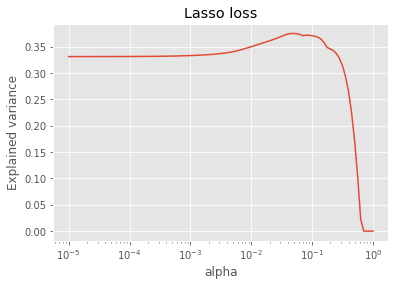

Best params: {'alpha': 0.048626015800653531}
Lasso explained variance: 0.0716363658591


Lasso(alpha=0.048626015800653531, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [160]:
plot_score(model=Lasso(), model_name='Lasso', X_train=X_train, y_train=y_train)
show_best_score(model=Lasso(), model_name='Lasso', param_grid={'alpha': np.logspace(-5, 0, 100)}, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:01<00:00, 89.08it/s]


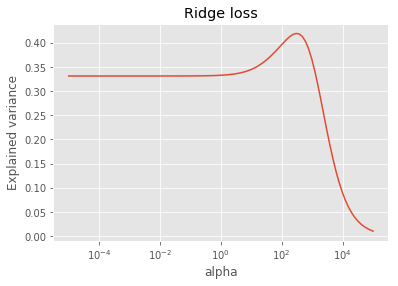

Best params: {'alpha': 298.36472402833402}
Ridge explained variance: 0.175407612919


In [161]:
plot_score(model=Ridge(), model_name='Ridge', X_train=X_train, y_train=y_train, param_space=np.logspace(-5, 5, 100))
model = show_best_score(model=Ridge(), model_name='Ridge',  param_grid={'alpha': np.logspace(-5, 5, 100)}, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:01<00:00, 50.59it/s]


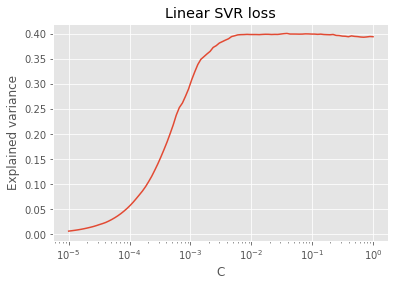

Best params: {'C': 0.038535285937105271}
Linear SVR explained variance: 0.281416468611


LinearSVR(C=0.038535285937105271, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [162]:
from sklearn.svm import SVR, LinearSVR
param_grid = {'C': np.logspace(-5, 0, 100)}

plot_score(model=LinearSVR(), model_name="Linear SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=LinearSVR(), model_name='Linear SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:14<00:00,  3.28it/s]


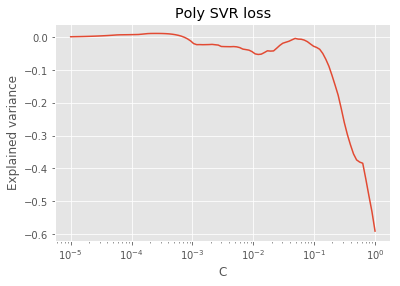

Best params: {'C': 0.15556761439304723, 'degree': 2}
Poly SVR explained variance: 0.138574065447


SVR(C=0.15556761439304723, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto', kernel='poly', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [138]:
param_grid = {'C': np.logspace(-5, 0, 100), "degree": [2, 3]}

model = SVR(kernel="poly", degree=3)

plot_score(model=model, model_name="Poly SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Poly SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:22<00:00,  2.40it/s]


Best params: {'C': 0.81113083078968728}
RBF SVR explained variance: 0.558282959028


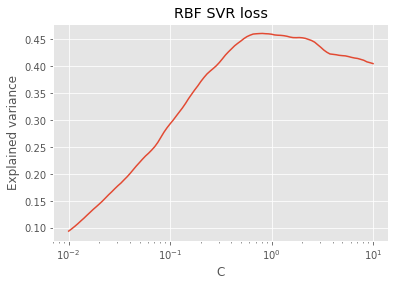

In [211]:
param_grid = {'C': np.logspace(-2, 1, 100), }

model = SVR(kernel="rbf")

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
model = show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 20/20 [00:09<00:00,  1.29s/it]


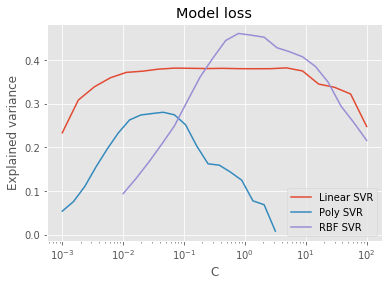

In [210]:
param_grid = {'C': np.logspace(-3, 2, 20)}
plot_score(model=LinearSVR(), model_name="Linear SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])

param_grid = {'C': np.logspace(-3, 0.5, 20), "degree": [2, 3]}
model = SVR(kernel="poly", degree=2)
plot_score(model=model, model_name="Poly SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])

param_grid = {'C': np.logspace(-2, 2, 20), }
model = SVR(kernel="rbf")
plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])

plt.title("Model loss")
plt.legend()

In [202]:
X[0]

array([  9.60000000e+01,   4.68000000e+01,   3.98633878e+01,
         3.09335947e+00,   2.00000000e+00,   1.00000000e+01,
         8.40000000e+00,   8.00000000e+00,   2.24600000e+03,
         1.00000000e+00,   1.00000000e+00,   0.00000000e+00])

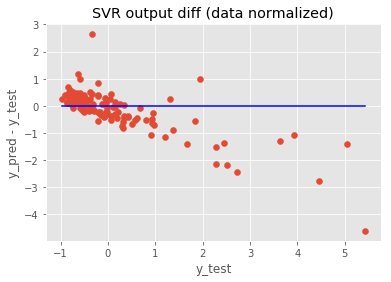

In [214]:
model.C = 1.0
model.fit(X_train, y_train)
plt.scatter(y_test, model.predict(X_test) - y_test)
plt.plot([y_test.min(), y_test.max()], [0, 0], color='blue')
plt.ylabel("y_pred - y_test")
plt.xlabel("y_test")
plt.title("SVR output diff (data normalized)")

Лучший результат - SVM с RBF ядром

Предположение:

1. [+] RBF можно улучшить, добавив координаты
1. [-] RBF похож на KNN, возможно, он покажет результаты лучше.

100%|██████████| 100/100 [00:21<00:00,  2.23it/s]


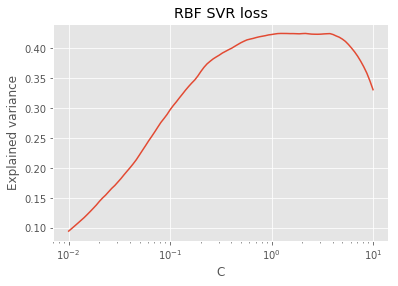

Best params: {'C': 2.1544346900318843}
RBF SVR explained variance: 0.623494983365


In [9]:
X = df.drop(["price", "info", "url"], axis=1).values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = df.price.values

X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

model = SVR(kernel="rbf")
param_grid = {'C': np.logspace(-2, 1, 100), }

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 45/45 [00:00<00:00, 45.89it/s]


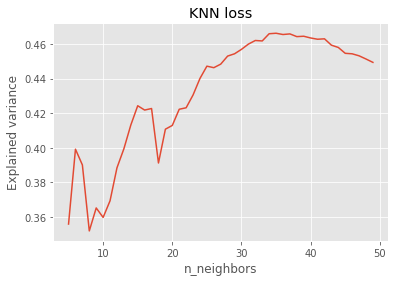

Best params: {'n_neighbors': 35}
KNN explained variance: 0.570022689584


In [10]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(weights="distance")
param_grid = {'n_neighbors': range(5, 50) }

plot_score(model=model, model_name="KNN", X_train=X_train, y_train=y_train, param_name="n_neighbors", param_space=param_grid["n_neighbors"], xscale="linear")
show_best_score(model=model, model_name='KNN',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Предположение: стоит проверить линейные модели только на основных данных: оценках и площади.

Получается хуже :-(

100%|██████████| 20/20 [00:03<00:00,  3.33it/s]


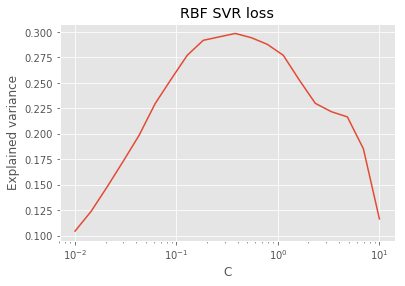

Best params: {'C': 0.37926901907322497}
RBF SVR explained variance: 0.473627679882


In [11]:
X = df[["room_size", "score", "votes"]].values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = df.price.values

X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

param_grid = {'C': np.logspace(-2, 1, 20), }

model = SVR(kernel="rbf")

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


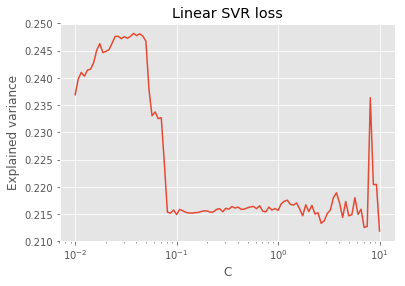

Best params: {'C': 0.028480358684358019}
Linear SVR explained variance: 0.385053692473


In [79]:
model = LinearSVR()
param_grid = {'C': np.logspace(-2, 1, 100), }

plot_score(model=model, model_name="Linear SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Linear SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


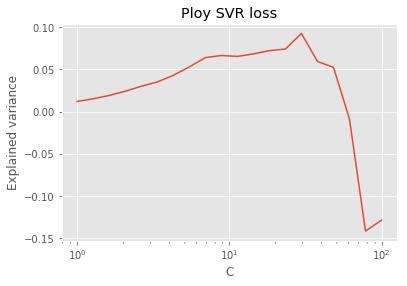

Best params: {'C': 29.763514416313178}
Poly SVR explained variance: 0.173471786222
Poly SVR RMSE: 10954.9984656
Poly SVR update RMSE: 0.151531168057


In [35]:
model = SVR(kernel="poly", degree=2)
param_grid = {'C': np.logspace(0, 2, 20), }

plot_score(model=model, model_name="Poly SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Poly SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

[-] Предположение: много информации можно извлечь из названия номера

In [184]:
dictionary = dict()
for keys in df["info"].str.split():
    for key in keys:
        dictionary[key] = dictionary.get(key, 0) + 1
        
sorted(([b, a] for a, b in dictionary.items()), reverse=True)

[[453, 'номер'],
 [446, 'с'],
 [443, 'Двухместный'],
 [344, 'кроватью'],
 [343, '1'],
 [238, '2'],
 [237, 'отдельными'],
 [237, 'кроватями'],
 [135, 'или'],
 [91, 'Апартаменты'],
 [33, 'Номер-студио'],
 [32, 'Вилла'],
 [31, 'Люкс'],
 [23, 'отпуска'],
 [23, 'для'],
 [23, 'Дом'],
 [3, 'Трехместный'],
 [3, 'Семейный'],
 [2, 'на'],
 [2, 'и'],
 [2, 'видом'],
 [2, 'Шале'],
 [1, 'сад'],
 [1, 'размера'],
 [1, 'море'],
 [1, 'дом'],
 [1, 'двухместный'],
 [1, 'балконом'],
 [1, 'Четырехместный'],
 [1, 'Улучшенный'],
 [1, 'Общий'],
 [1, 'Мобильный'],
 [1, 'Делюкс'],
 [1, 'Бюджетный'],
 [1, 'Бунгало'],
 [1, '×'],
 [1, '"king-size"/']]

In [185]:
# pd.get_dummies(df["info"].str.split())
good_words = ['Двухместный', 'кроватями', 'кроватью'] # 'Апартаменты', 'Вилла', 'Номер-студио', 'Дом', 'Люкс', 
one_hot = pd.get_dummies(df["info"].str.split().apply(pd.Series).stack()).sum(level=0)[good_words]
df = df.join(one_hot)

In [187]:
df.max()

airport1_km                                                      150
airport2_km                                                     65.9
info                                                        \nШале\n
latitude                                                     39.9211
longitude                                                    3.46965
person_count                                                      12
price                                                        6.02552
room_size                                                        638
score                                                             10
sightseen_count                                                   10
url                /hotel/es/zhero.ru.html?aid=304142;label=gen17...
votes                                                           3927
Двухместный                                                        1
кроватями                                                          1
кроватью                          

In [189]:
X = df.drop(["price", "info", "url"], axis=1).values
# X -= X.mean(axis=0)
# X /= X.std(axis=0)
y = df.price.values

X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

In [190]:
from sklearn.model_selection import KFold

class Preprocessing(object):
    TEXT_CLASSES = 3
    
    def __init__(self):
        self.avr = np.zeros(self.TEXT_CLASSES)
        
    def fit(self, X_train, y_train):
        X_train = X_train[:, -self.TEXT_CLASSES:]
        la = np.dstack([X_train, 1 - X_train])
        self.avr = (la * y_train[:, np.newaxis, np.newaxis]).sum(axis=0) / la.sum(axis=0)
        return self
    
    def transform(self, X_test):
        X_test = X_test.copy()
        for i in range(self.TEXT_CLASSES):
            X_test[:, i - self.TEXT_CLASSES] = self.avr[i, X_test[:, i - self.TEXT_CLASSES].astype(int)]
        
        X_test[:-self.TEXT_CLASSES] -= X_test[:-self.TEXT_CLASSES].mean(axis=0)
        X_test[:-self.TEXT_CLASSES] /= X_test[:-self.TEXT_CLASSES].std()
        
        return X_test
    
    def fit_transform(self, X_train, y_train):
        kf = KFold(n_splits=10, shuffle=False)
        result = []
        
        for train, transform in kf.split(X_train):
            result.append(self.fit(X_train[train], y_train[train]).transform(X_train[transform]))
        
        return np.vstack(result)

preprop = Preprocessing()
X_train = preprop.fit_transform(X_train, y_train)
X_test = preprop.fit(X_train, y_train).transform(X_test)

100%|██████████| 100/100 [04:41<00:00, 25.88s/it]


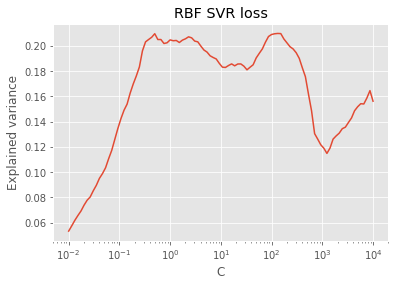

Best params: {'C': 0.49770235643321115}
RBF SVR explained variance: 0.44886154497


SVR(C=0.49770235643321115, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [192]:
model = SVR(kernel="rbf")
param_grid = {'C': np.logspace(-2, 4, 100), }

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 20/20 [00:05<00:00,  3.19it/s]


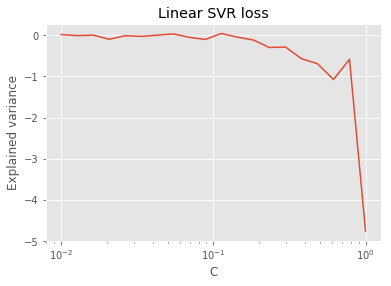

Best params: {'C': 0.012742749857031334}
Linear SVR explained variance: -0.0626513044782


In [18]:
model = LinearSVR()
param_grid = {'C': np.logspace(-2, 0, 20), }

plot_score(model=model, model_name="Linear SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Linear SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [19]:
model = SVR(kernel="poly", degree=2)
param_grid = {'C': np.logspace(-2, 1, 20), }

plot_score(model=model, model_name="Poly SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Poly SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

Предположение: хорошо отработают модели на деревьях, так как координаты для этого неплохо подходят.

In [ ]:
def show_best_randomized_score(model, model_name, param_grid, X_train, y_train, X_test, y_test):
    gs = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=10, n_jobs=-1, scoring='explained_variance', verbose=1)
    gs.fit(X_train, y_train)
    
    print("Best params:", gs.best_params_)
    
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_score = explained_variance_score(y_test, y_pred)
    print("{model_name} explained variance:".format(model_name=model_name), model_score)
    model_score = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{model_name} RMSE:".format(model_name=model_name), model_score)
    print("{model_name} update RMSE:".format(model_name=model_name), (baseline_score - model_score) / baseline_score)

In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
param_grid = {
    "n_estimators": [5, 10, 20, 50, 100, 150, 200],
    "max_depth": [None, 2, 3, 4, 5],
}

show_best_score(model=model, model_name='Random forest',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Best params: {'n_estimators': 10, 'max_depth': 4}
Random forest explained variance: 0.433282215022


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
param_grid = {
    "loss": ['ls', 'lad', 'huber', 'quantile'],
    "learning_rate": [0.01, 0.1, 0.5, 0.8],
    "n_estimators": [5, 10, 50, 200],
    "max_depth": [None, 2, 3, 4, 5],
}

show_best_score(model=model, model_name='Gradient boosting',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Best params: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 4, 'n_estimators': 50}
Gradient boosting explained variance: 0.477055991098


In [174]:
markers = pd.read_csv("data/data.csv", sep="\t", encoding='utf-8', index_col=0)[["latitude", "longitude", "price"]]
markers = markers[markers.price < 200000]
# markers.price = np.log(markers.price.values)

In [142]:
import folium
m = folium.Map(location=[markers.latitude.median(), markers.longitude.median()], zoom_start=9)

min_price, max_price = markers.price.min(), markers.price.max()
dis_price = max_price - min_price

def color(price):
    price -= min_price
    price /= dis_price
    red = int(price * 255)
    green = 255 - red
    blue = 0
    return '#' + hex(red * 256 ** 2 + green * 256 + blue)[2:].rjust(6, '0')

for i in range(len(markers)):
    folium.Circle(
        radius=100,
        location=[markers.latitude.values[i], markers.longitude.values[i]],
        color=color(markers.price.values[i]),
        popup=str(markers.price.values[i]),
        fill=False,
    ).add_to(m)

m

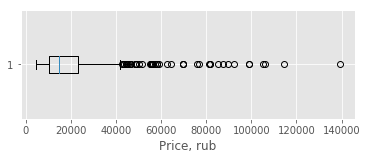

In [183]:
plt.figure(figsize=(6, 2))
plt.boxplot(markers.price.values, vert=False)
plt.xlabel('Price, rub')

In [51]:
help(str.ljust)

Help on method_descriptor:

ljust(...)
    S.ljust(width[, fillchar]) -> str
    
    Return S left-justified in a Unicode string of length width. Padding is
    done using the specified fill character (default is a space).

